In [1]:
## test example of using Temporal fusion transformer

In [2]:
from darts import TimeSeries

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

/opt/anaconda3/envs/tfp/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: R2022a is an invalid version and will not be supported in a future release
  warnings.warn(
The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [29]:
from pipeline import import_data, base_process_data, feature_normalization, ensemble_predict, temporal_process_data
from utils import cd_root_dir, save2Vis

In [5]:
%load_ext autoreload
%autoreload 2


In [6]:
%matplotlib widget

In [7]:
# set up a global plt style for the script
# plt.style.use('classic')
plt.rcParams.update({
        "font.size": 9,
        "text.usetex": True,
        "font.family": "serif",
        "figure.figsize": (4, 3),
        "legend.fontsize": 'medium',
        })

In [8]:
# tf.random.set_seed(9527)

In [9]:
cd_root_dir()

current directory: /Users/lesliec/Documents/Github_repos/KTP_Croud/KTP_Croud


# import the data

In [10]:
# import the data and get the time axis !
dataset, time_axis = import_data(path='data/raw/weekly_media_sample.csv')

In [11]:
time_axis = pd.to_datetime(time_axis, format='%d/%m/%Y')

In [12]:
# plot the val results
val_x_axis = np.arange(200, 208)

In [13]:
train_df, val_df = temporal_process_data(dataset, split_index=200)

Processed dataset shape:  (208, 7)


In [14]:
train_df.shape

(200, 7)

In [15]:
train_df.head()

,revenue,media1_S,media2_S,media3_S,competitor_sales,newsletter,year_sin
0,1.336430,0.251134,1.422358,1.838231,1.297616,-0.118711,0.155231
1,1.099240,0.466640,-0.571763,-0.311544,1.189288,-0.373604,0.337454
2,1.047799,-0.519174,-0.500657,0.724051,1.382543,-0.387260,0.513386
3,1.504948,2.355924,2.198091,0.239946,1.296585,-1.036511,0.680018
4,0.585630,-0.519174,-0.571763,-0.461964,0.803617,-0.335625,0.834499


In [16]:
train_df.columns

Index(['revenue', 'media1_S', 'media2_S', 'media3_S', 'competitor_sales',
       'newsletter', 'year_sin'],
      dtype='object')

In [17]:
val_df.shape

(8, 7)

In [18]:
train_target = TimeSeries.from_series(train_df['revenue'])

In [19]:
train_features = TimeSeries.from_dataframe(train_df[['media1_S', 'media2_S', 'media3_S', 'competitor_sales',
       'newsletter', 'year_sin']])

In [20]:
val_target = TimeSeries.from_series(val_df['revenue'])

In [21]:
val_features = TimeSeries.from_dataframe(val_df[['media1_S', 'media2_S', 'media3_S', 'competitor_sales',
       'newsletter', 'year_sin']])

# build the TFT model

In [22]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.5,
    0.95,
    0.99,
]

input_chunk_length = 4
forecast_horizon = 1

my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=True,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

In [23]:
my_model.fit(
    series=train_target, 
    past_covariates=train_features,
    verbose=True)

Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x7fb63772ee80>, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=4, output_chunk_length=1, batch_size=16, n_epochs=300, add_encoders=None, random_state=42)

In [24]:
from darts.explainability import TFTExplainer

In [25]:
explainer = TFTExplainer(my_model)

In [26]:
explainability_result = explainer.explain()

Predicting: 0it [00:00, ?it/s]

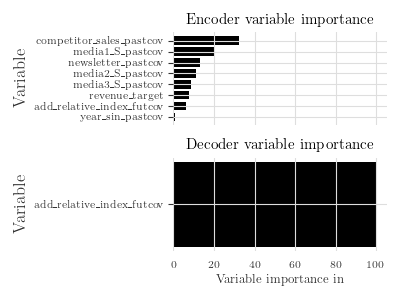

In [30]:
explainer.plot_variable_selection(explainability_result)
save2Vis('TFT_variable_importance')